In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
from IPython.display import HTML
style = "<style>div.warn { background-color: #fcf2f2;border-color: #dFb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;}</style>"
HTML(style)

Infering missing values (crashed calculations) ... !!!

In [6]:
wc_mm = pd.read_csv("GAS_PHASE/WC/ENERGY_mm.csv", names=['Frame', 'Ener'])
wc_qm = pd.read_csv("GAS_PHASE/WC/ENERGY_qmmm.csv", names=['Frame', 'Ener'])
print(np.sum(wc_qm.isnull()))

Frame    0
Ener     1
dtype: int64


In [7]:
# filling NaNs with means since there are just 
wc_qm = wc_qm.apply(lambda x: x.fillna(x.mean()),axis=0)
print(np.sum(wc_qm.isnull()))

Frame    0
Ener     0
dtype: int64


In [14]:
ts_mm = pd.read_csv("GAS_PHASE/TS_RH/ENERGY_mm.csv", names=['Frame', 'Ener'])
ts_qm = pd.read_csv("GAS_PHASE/TS_RH/ENERGY_qmmm.csv", names=['Frame', 'Ener'])
print(np.sum(ts_qm.isnull()))

Frame    0
Ener     0
dtype: int64


In [98]:
hg_mm = pd.read_csv("GAS_PHASE/HG/ENERGY_mm.csv", names=['Frame', 'Ener'])
hg_qm = pd.read_csv("GAS_PHASE/HG/ENERGY_qmmm.csv", names=['Frame', 'Ener'])
print(np.sum(hg_qm.isnull()))

Frame    0
Ener     2
dtype: int64


In [99]:
hg_qm = hg_qm.apply(lambda x: x.fillna(x.mean()),axis=0)
print(np.sum(hg_qm.isnull()))

Frame    0
Ener     0
dtype: int64


<div class="warn"><font size="4"><h3 align="center">GAS PHASE SINGLE POINTS</h3> </div>

   + no waters or ions here. Central trimer in the double standed DNA is considered as QM (218 atoms). 
   + Level of theory: blyp/6-31g*

<div class="warn"><font size="4"><h3 align="center">GAS PHASE SINGLE POINTS</h3> </div>

<font size="6", color='red'><h3 align="center">ENERGY BARRIERS</h3>

# some bootstrapping here
   + We have 500 single points of wc, ts and hg structures (selected according to our Umbrella 2D Free Energy calculations. Structures were selected so that the variables Xi and CPDDb as are as much as 5 degrees apart of their theoretical values.
   + For bootstrapping we basically take i random pairs of wc and ts and compute energy barriers as E(wc) - E(ts). (I took 300 pairs below). This is repeated J times so that you have j (I did 1k times) number of data populations. 

In [74]:
def boostraping_pairs(minima_array_qm, maximun_array_qm, minima_array_mm, maximun_array_mm, n=1000, pairs=300):
    ### giving two arrays of energies (minima assumed is from WC structures
    # and maxima from TS or HG) defines random 'pairs' between these sets and computes energy differences
    # This is done for mm and qmmmm energies
    # It finally returns the arrays of means of such energy differences from 'n' experiments at the mm and qmmmm level
    
    barriers_qm_mean = []
    barriers_mm_mean = []
    
    for n in range(1,n+1):
        i, j = np.random.randint(1, 500, pairs), np.random.randint(1, 500, pairs)
        barriers_qm_mean.append(np.mean(maximun_array_qm.loc[i]['Ener'].values - minima_array_qm.loc[j]['Ener'].values))
        barriers_mm_mean.append(np.mean(maximun_array_mm.loc[i]['Ener'].values - minima_array_mm.loc[j]['Ener'].values))
            
    return (barriers_qm_mean, barriers_mm_mean)

In [75]:
avg_barriers_qm, avg_barriers_mm = boostraping_pairs(wc_qm, ts_qm, wc_mm, ts_mm, n=10000)

In [104]:
dic_mm = {'Ebarrier': avg_barriers_mm,
      'type':'MM',
      'phase':'Gas_Phase'}

dic_qm = {'Ebarrier': avg_barriers_qm,
      'type':'QM',
      'phase':'Gas_Phase'}

df_mm, df_qm = pd.DataFrame(dic_mm), pd.DataFrame(dic_qm)
df = df_mm.append(df_qm)

In [105]:
df.groupby('type').mean()

,Ebarrier
type,
MM,16.538934
QM,13.065231


**Notice here how close are these means to the experimental + 16 kcal/mol value**.

** According to the US-2D calculations this energy was + 10.25 kcal/mol **

However we probably should not be comparing our results here to free energies (experimental = 16 kcal/mol) but with with experimental entalpies (12 to 26 kcal/mol). All these values are in [Original Al-hashimi paper Nature2011](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074620/).

In the second paper of Al-Hashimi on this they are not reporting enthalpies at all but just free energies (again about 16 kcal/mol) in all the sequences they considered [Paper with different sequences](https://www.nature.com/articles/ncomms5786#supplementary-information)

In [41]:
df.groupby('type').std()

,Ebarrier
type,
MM,4.941406
QM,4.979422


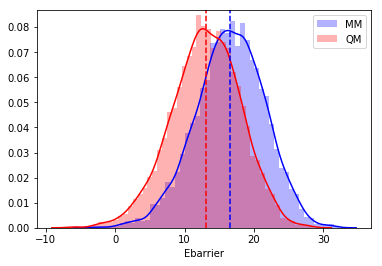

In [78]:
sns.distplot(df.loc[df.type == 'MM']['Ebarrier'], color='b', label='MM', hist_kws={"alpha": 0.3})
sns.distplot(df.loc[df.type == 'QM']['Ebarrier'], color='r', label='QM', hist_kws={"alpha": 0.3})
plt.axvline(np.mean(df.loc[df.type == 'MM']['Ebarrier']), color='b', linestyle='--')
plt.axvline(np.mean(df.loc[df.type == 'QM']['Ebarrier']), color='r', linestyle='--')
plt.legend()
plt.show()

**Note that the distribution is quite broad so that there are good chances of having means in a broad range also:**

In [79]:
# let's see the 10th and 90th percentiles 
np.percentile(df.loc[df.type == 'MM']['Ebarrier'], [10, 90])

array([ 10.19126413,  22.71809853])

<font color='red'>10th and 90th Percentiles indicates range of values of 10-22 kcal/mol, **where the esperimental value (i.e 16 kcal/mol) is included** .</font>

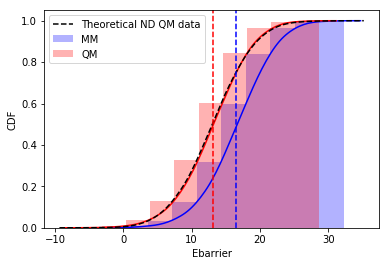

In [80]:
sns.distplot(df.loc[df.type == 'MM']['Ebarrier'], color='b', bins=10, 
             hist_kws=dict(cumulative=True, alpha=0.3), kde_kws=dict(cumulative=True), label='MM')
sns.distplot(df.loc[df.type == 'QM']['Ebarrier'], color='r', bins=10,
            hist_kws=dict(cumulative=True, alpha=0.3), kde_kws=dict(cumulative=True), label='QM', )


mean=np.mean(df.loc[df.type == 'QM']['Ebarrier'])
std=np.std(df.loc[df.type == 'QM']['Ebarrier'])
size=len(df.loc[df.type == 'QM'])
#print(mean, std, size)
t_qm = np.random.normal(mean, std, size)

sns.kdeplot(t_qm, color='black', cumulative=True, label='Theoretical ND QM data', linestyle='--')

plt.axvline(np.mean(df.loc[df.type == 'MM']['Ebarrier']), color='b', linestyle='--')
plt.axvline(np.mean(df.loc[df.type == 'QM']['Ebarrier']), color='r', linestyle='--')
plt.ylabel('CDF')
plt.legend()
plt.show()

Theoretical ND (Normal Distribution) QM Data is just the theoretical ND with same mean and std as observered in population of QM sp calculations. The similarity with the actual QM distribution just confirm that means of energy barriers follow a ND (as expected)

<font color='red'>At first sight MM and QM/MM distributions of energy barriers look quite similar but MM energy barriers appear to be about 3 kcal/mol higher than QMMMM energies. Let's run some statistics to see if it is statistically significant. </font>

# Null Hypothesis Significance Testing (NHST) MM vs QM
   + null hypothesis: means of QMMM and MM energy barriers follow the same normal distribution

In [81]:
def p_value_mm_vs_qm(df, n=10000, diff=5.0):
    
    # generates a permutation sample giving the hypothesis that mm and qmmmm distributions are identical
    # then splits data and computes means of new distributions of mm and qmmmm
    # returns the p-value
    
    full_Ebarriers = np.array(df.Ebarrier)
    
    count=np.zeros(n)

    for i in range(n):
        
        perm_Ebarriers = np.random.permutation(full_Ebarriers)
        perm_Ebarriers_MM = perm_Ebarriers[:len(df.loc[df.type == 'MM'])]
        perm_Ebarriers_QM = perm_Ebarriers[len(df.loc[df.type == 'MM']):]

        count[i]= (np.mean(perm_Ebarriers_MM) - np.mean(perm_Ebarriers_QM)) >= diff
    
    return format(np.sum(count)/n, '.4f')

In [82]:
# So what's the chance that MM barriers are actually higher than QMMMM barriers by at least 3 kcal/mol as observed?
p_value_mm_vs_qm(df, n=10000, diff=3.0)

'0.0000'

**With a p-value of 0.0 seems that distributions of means of MM barries are actually higher by at least 3 kcal/mol**.

And what's the chance of having a mean value of at least let's say 14 kcal/mol for the mm calculations ?

In [126]:
float(sum(df.loc[df.type == 'MM']['Ebarrier'] >= 14.0)) / len(df.loc[df.type == 'MM'])

0.7062

<font size="6", color='red'><h3 align="center">MORAL</h3>

   + according to this analysis there is a 70 % of chance that giving a population of energy barriers at the MM level their mean is at least of 14 kcal/mol (remember the experimental value is of 16 kcal/mol)

<font size="4", color='red'>Could we just it this analysis and forget about our deviation in the umbrella runs with respect to the experimental value? ... Even if we have been computing gas phase enthalpies ? Maybe :)</h3>

<font size="6", color='red'><h3 align="center">REACTION ENERGIES</h3>

# some bootstrapping here
   + We have 500 single points of wc, ts and hg structures (selected according to our Umbrella 2D Free Energy calculations. Structures were selected so that the variables Xi and CPDDb as are as much as 5 degrees apart of their theoretical values.
   + For bootstrapping we basically take 'pairs' random pairs of wc and ts and compute energy barriers as E(wc) - E(ts).This is repeated n times. 

In [100]:
avg_reaction_qm, avg_reaction_mm = boostraping_pairs(wc_qm, hg_qm, wc_mm, hg_mm, n=100000, pairs=200)

In [106]:
dic_mm = {'Ebarrier': avg_reaction_mm,
      'type':'MM',
      'phase':'Gas_Phase'}

dic_qm = {'Ebarrier': avg_reaction_qm,
      'type':'QM',
      'phase':'Gas_Phase'}

df_mm_reaction, df_qm_reaction = pd.DataFrame(dic_mm), pd.DataFrame(dic_qm)
df_reaction = df_mm_reaction.append(df_qm)

In [107]:
df_reaction.groupby('type').mean()

,Ebarrier
type,
MM,15.554047
QM,13.065231


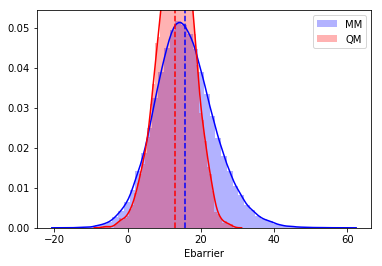

In [108]:
sns.distplot(df_reaction.loc[df_reaction.type == 'MM']['Ebarrier'], color='b', label='MM', hist_kws={"alpha": 0.3})
sns.distplot(df_reaction.loc[df_reaction.type == 'QM']['Ebarrier'], color='r', label='QM', hist_kws={"alpha": 0.3})
plt.axvline(np.mean(df_reaction.loc[df_reaction.type == 'MM']['Ebarrier']), color='b', linestyle='--')
plt.axvline(np.mean(df_reaction.loc[df_reaction.type == 'QM']['Ebarrier']), color='r', linestyle='--')
plt.legend()
plt.show()

**Values are to high here, according to US-2D was 2.5 kcal/mol and Al-Hashimi report values of 3 +- 0.5 kcal/mol. so in this case we were already in good agreement**

In [109]:
df_reaction.groupby('type').std()

,Ebarrier
type,
MM,8.189491
QM,4.978060


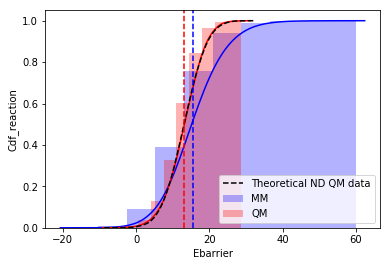

In [110]:
sns.distplot(df_reaction.loc[df_reaction.type == 'MM']['Ebarrier'], color='b', bins=10, 
             hist_kws=dict(cumulative=True, alpha=0.3), kde_kws=dict(cumulative=True), label='MM')
sns.distplot(df_reaction.loc[df_reaction.type == 'QM']['Ebarrier'], color='r', bins=10,
            hist_kws=dict(cumulative=True, alpha=0.3), kde_kws=dict(cumulative=True), label='QM', )


mean=np.mean(df_reaction.loc[df_reaction.type == 'QM']['Ebarrier'])
std=np.std(df_reaction.loc[df_reaction.type == 'QM']['Ebarrier'])
size=len(df_reaction.loc[df_reaction.type == 'QM'])
#print(mean, std, size)
t_qm = np.random.normal(mean, std, size)

sns.kdeplot(t_qm, color='black', cumulative=True, label='Theoretical ND QM data', linestyle='--')

plt.axvline(np.mean(df_reaction.loc[df_reaction.type == 'MM']['Ebarrier']), color='b', linestyle='--')
plt.axvline(np.mean(df_reaction.loc[df_reaction.type == 'QM']['Ebarrier']), color='r', linestyle='--')
plt.ylabel('Cdf_reaction')
plt.legend()
plt.show()

In [96]:
# let's see the 10th and 90th percentiles 
np.percentile(df_reaction.loc[df.type == 'MM']['Ebarrier'], [10, 90])

array([  7.27024233,  24.3083224 ])

<font size="4", color='red'>some how the same analysis is not working for reaction energies, trying to figure out why, or since our problem is just with the energy barriers and not reaction energies we could probably just refer to the first ? Look a little bit like cheating though. Double checked that energies actually came from HG structures etc</h3>

<div class="warn"><font size="4"><h3 align="center">FULL PHASE SINGLE POINTS</h3> </div>
   + here the water molecules and ions within 10 A of the nucleic acids where preserved in QM/MM calculations. QM partition as well as level of theory was the same as in the Gas Phase calculations. 

In [128]:
wc_mm_full = pd.read_csv("FULL_PHASE/WC/ENERGY_mm.csv", names=['Frame', 'Ener'])
wc_qm_full = pd.read_csv("FULL_PHASE/WC/ENERGY_qmmm.csv", names=['Frame', 'Ener'])

wc_qm_full = wc_qm_full.apply(lambda x: x.fillna(x.mean()),axis=0)

In [129]:
ts_mm_full = pd.read_csv("FULL_PHASE/TS_RH/ENERGY_mm.csv", names=['Frame', 'Ener'])
ts_qm_full = pd.read_csv("FULL_PHASE/TS_RH/ENERGY_qmmm.csv", names=['Frame', 'Ener'])

ts_qm_full = ts_qm_full.apply(lambda x: x.fillna(x.mean()),axis=0)

In [130]:
hg_mm_full = pd.read_csv("FULL_PHASE/HG/ENERGY_mm.csv", names=['Frame', 'Ener'])
hg_qm_full = pd.read_csv("FULL_PHASE/HG/ENERGY_qmmm.csv", names=['Frame', 'Ener'])

hg_qm_full = hg_qm_full.apply(lambda x: x.fillna(x.mean()),axis=0)

In [131]:
avg_barriers_qm, avg_barriers_mm = boostraping_pairs(wc_qm_full, ts_qm_full, wc_mm_full, ts_mm_full, n=10000)

In [132]:
dic_mm = {'Ebarrier': avg_barriers_mm,
      'type':'MM',
      'phase':'Full_Phase'}

dic_qm = {'Ebarrier': avg_barriers_qm,
      'type':'QM',
      'phase':'Full_Phase'}

df_mm_full, df_qm_full = pd.DataFrame(dic_mm), pd.DataFrame(dic_qm)
df_full = df_mm_full.append(df_qm_full)

In [133]:
df_full.groupby('type').mean()

,Ebarrier
type,
MM,-13.440099
QM,-15.253192


In [134]:
df_full.groupby('type').std()

,Ebarrier
type,
MM,32.306901
QM,32.272509


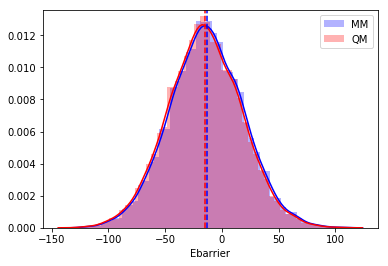

In [135]:
sns.distplot(df_full.loc[df_full.type == 'MM']['Ebarrier'], color='b', label='MM', hist_kws={"alpha": 0.3})
sns.distplot(df_full.loc[df_full.type == 'QM']['Ebarrier'], color='r', label='QM', hist_kws={"alpha": 0.3})
plt.axvline(np.mean(df_full.loc[df_full.type == 'MM']['Ebarrier']), color='b', linestyle='--')
plt.axvline(np.mean(df_full.loc[df_full.type == 'QM']['Ebarrier']), color='r', linestyle='--')
plt.legend()
plt.show()

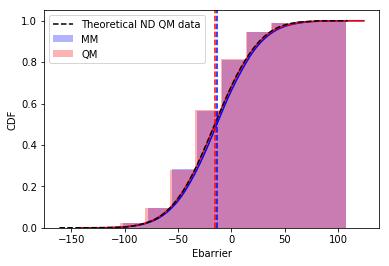

In [136]:
sns.distplot(df_full.loc[df_full.type == 'MM']['Ebarrier'], color='b', bins=10, 
             hist_kws=dict(cumulative=True, alpha=0.3), kde_kws=dict(cumulative=True), label='MM')
sns.distplot(df_full.loc[df_full.type == 'QM']['Ebarrier'], color='r', bins=10,
            hist_kws=dict(cumulative=True, alpha=0.3), kde_kws=dict(cumulative=True), label='QM', )


mean=np.mean(df_full.loc[df_full.type == 'QM']['Ebarrier'])
std=np.std(df_full.loc[df_full.type == 'QM']['Ebarrier'])
size=len(df_full.loc[df_full.type == 'QM'])
#print(mean, std, size)
t_qm = np.random.normal(mean, std, size)

sns.kdeplot(t_qm, color='black', cumulative=True, label='Theoretical ND QM data', linestyle='--')

plt.axvline(np.mean(df_full.loc[df_full.type == 'MM']['Ebarrier']), color='b', linestyle='--')
plt.axvline(np.mean(df_full.loc[df_full.type == 'QM']['Ebarrier']), color='r', linestyle='--')
plt.ylabel('CDF')
plt.legend()
plt.show()

# All together Gas Phase and Full Phase: energy barriers

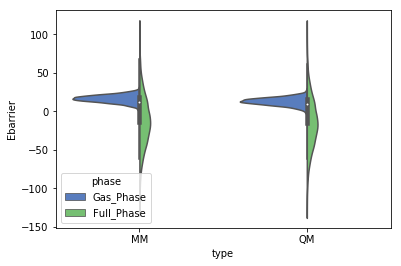

In [138]:
df_all = df.append(df_full)

sns.violinplot(x='type', y='Ebarrier', data=df_all, hue='phase', palette="muted", split=True)
plt.show()

** Here we obtain a more broad distribution, which make sense giving the 'noise' introduced by water and ions ** Remember that even if waters and ions are mm their number may differ between different structures ... I should try new version of terachem to see if I can do single points with the entire frames without removing waters etc as done here.